In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import pickle
from pymoo.indicators.hv import HV
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from problem import get_problem

In [2]:
color_code = ['red', 'grey', 'brown', 'orange', 'blue', 'green', 'purple']

methods = ['DGEMO', 'MOEAD-EGO', 'TS-TCH', 'TSEMO', 'USEMO-EI', 'PSL-MOBO', 'Co-PSL']

In [3]:
def plot_compare2(problem_name = "DTLZ2", n_dim = 5):
    log_dir = f"weight/{problem_name}_{n_dim}_dim"
    
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = np.load(f'{log_dir}/TrueParetoFront.npy') 
    max_HV = hv(truth_pareto)
    
    k =0
    
    for method in methods:
        Y_evaluation = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_{method}.npy')[:420]
        # print(Y_evaluation.shape)
        hv_result = []
        for i in range(Y_evaluation.shape[0]):
            hv_result.append(hv(Y_evaluation[:i]))   
        np.save(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}.npy', hv_result)     
        
        plt.plot(np.log(np.clip(max_HV - hv_result, a_min=1e-14, a_max=max_HV)), color=color_code[k], linewidth=1, label=f"{method}")
        k += 1
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Number of evaluation")
    plt.title(f"{problem_name}")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.45), ncols=3)
    plt.savefig(f"visualization_plot/Result_LHD_{problem_name}.pdf", bbox_inches='tight')
    plt.show()

In [4]:
def plot_compare(problem_name = "DTLZ2", n_dim = 5):
    log_dir = f"weight/{problem_name}_{n_dim}_dim"
    
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = np.load(f'{log_dir}/TrueParetoFront.npy') 
    max_HV = hv(truth_pareto)
    
    k =0
    
    for method in methods:
        hv_result = np.load(f'{log_dir}/HV_{problem_name}_Y_{n_dim}_{method}.npy')
        if problem_name == "RE36":
            hv_result = hv_result[:320]
        
        plt.plot(np.log(np.clip(max_HV - hv_result, a_min=1e-14, a_max=max_HV)), color=color_code[k], linewidth=1, label=f"{method}")
        k += 1
    # plt.axvline(x = 220, color = 'black', linestyle='dashed', linewidth = 1)
    
    plt.ylabel("Log Hypervolume difference")
    plt.xlabel("Number of evaluation")
    if problem_name == "RE36":
        plt.xticks([20, 70, 120, 170, 220, 270, 320])
    else:
        plt.xticks([20, 70, 120, 170, 220, 270, 320, 370, 420])
    plt.grid()
    plt.title(f"{problem_name}")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.45), ncols=3)
    plt.savefig(f"visualization_plot/Result_LHD_{problem_name}.pdf", bbox_inches='tight')
    plt.show()

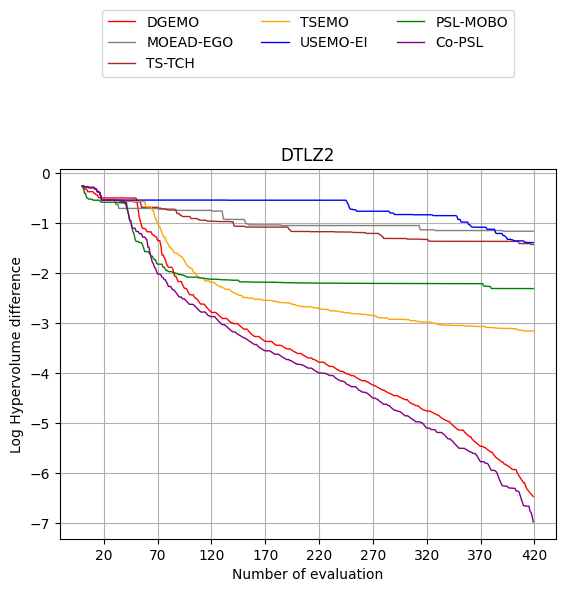

In [5]:
plot_compare("DTLZ2", n_dim = 6)

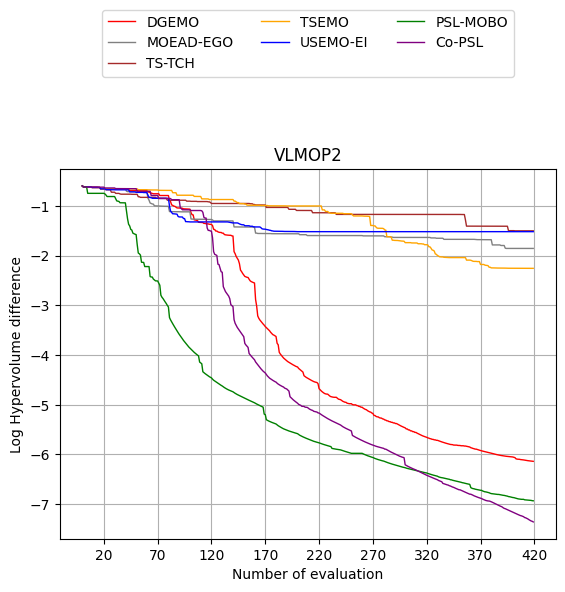

In [6]:
plot_compare("VLMOP2", n_dim = 4)

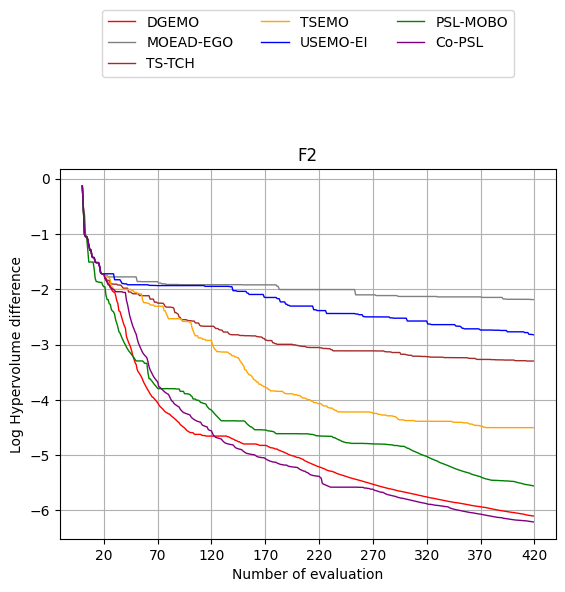

In [7]:
plot_compare("F2", n_dim = 6)

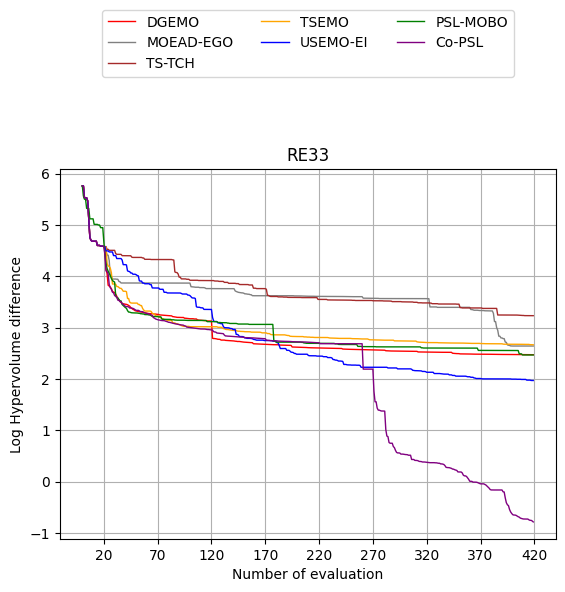

In [8]:
plot_compare("RE33", n_dim = 4)

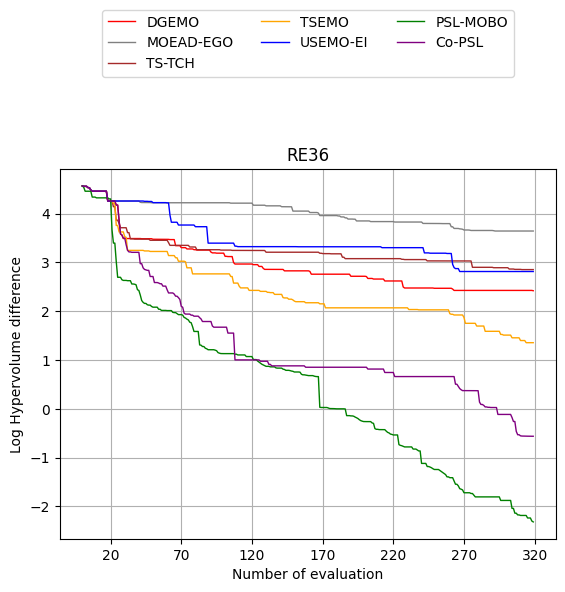

In [9]:
plot_compare("RE36", n_dim = 4)

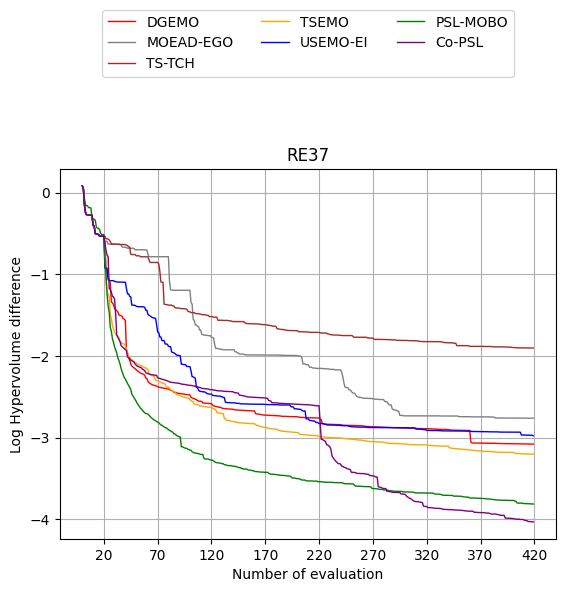

In [10]:
plot_compare("RE37", n_dim = 4)